In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import warnings 
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [6]:
warnings.filterwarnings(action = 'ignore')

In [7]:
train = pd.read_csv('C:/Users/whileduck/Downloads/playground-series-s3e12/train.csv')
test = pd.read_csv('C:/Users/whileduck/Downloads/playground-series-s3e12/test.csv')

In [8]:
df = train.copy()

In [9]:
X = df.drop(['id','target'],axis = 1)
Y = df['target']

In [10]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,stratify = Y, test_size = 0.2, random_state = 42)

# Optuna

### Optuna is a hyperparameter optimization framework that allows you to optimize machine learning models by tuning their hyperparameters. XGBoostClassifier can be used with Optuna to find the optimal values of its hyperparameters.

In [11]:
def objective(trial):
    # Define the hyperparameters to be optimized by Optuna
    param = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 42
    }
    
    # Create and train the XGBoostClassifier model with the sampled hyperparameters
    model = XGBClassifier(**param)
    model.fit(x_train, y_train)
    
    # Compute the AUC score on the test set
    score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    
    return score

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-04-09 15:11:06,344] A new study created in memory with name: no-name-c9a9c2c7-a51b-4b95-b0ad-5c06f2182499
[I 2023-04-09 15:11:06,562] Trial 0 finished with value: 0.7364864864864865 and parameters: {'n_estimators': 605, 'learning_rate': 0.0005181413411290862, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.23117891442045532, 'colsample_bytree': 0.6623149030208159, 'gamma': 0.07300956912381103, 'reg_alpha': 0.0885563544648004, 'reg_lambda': 0.011078960713779534}. Best is trial 0 with value: 0.7364864864864865.
[I 2023-04-09 15:11:06,746] Trial 1 finished with value: 0.7708578143360753 and parameters: {'n_estimators': 374, 'learning_rate': 0.017882676486466208, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.23417692918377786, 'colsample_bytree': 0.20871230387450762, 'gamma': 0.009504213852402011, 'reg_alpha': 1.5061567922186324e-06, 'reg_lambda': 2.5291511885305995e-06}. Best is trial 1 with value: 0.7708578143360753.
[I 2023-04-09 15:11:06,898] Trial 2 finished wit

In [13]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.8113983548766158,
params {'n_estimators': 362, 'learning_rate': 0.020157412965536938, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5112049301138453, 'colsample_bytree': 0.5257029128071002, 'gamma': 0.00579012414041011, 'reg_alpha': 0.027457211745494217, 'reg_lambda': 0.0002525389978700006}


In [14]:
import optuna.visualization as vis

# Assuming that 'study' is your Optuna study object
# Visualize parameter importance
fig = vis.plot_param_importances(study)
fig.show()

In [15]:
# Visualize slice plot
fig = vis.plot_slice(study)
fig.show()

In [16]:
# Visualize parallel coordinate plot
fig = vis.plot_parallel_coordinate(study)
fig.show()

In [17]:
# Visualize optimization history plot
fig = vis.plot_optimization_history(study)
fig.show()

In [18]:
param_grid = {'n_estimators': 588, 'learning_rate': 0.010914601022630038, 
                 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.36983544183139816,
                 'colsample_bytree': 0.669791309156759, 'gamma': 0.11302676094204718, 
                 'reg_alpha': 4.04019319197943e-08, 'reg_lambda': 0.4203077089763021}

model = XGBClassifier(**param_grid)

# ROC_Curve [train,validation set]

In [19]:
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.669791309156759, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.11302676094204718, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.010914601022630038, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=588, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
train_proba = model.predict_proba(x_test)[:,1]


fpr,tpr, _ = roc_curve(y_test,train_proba)
auc_score = round(roc_auc_score(y_test,train_proba),3)

Text(0.5, 1.0, 'XGBoostClassifier ROC_CURVE')

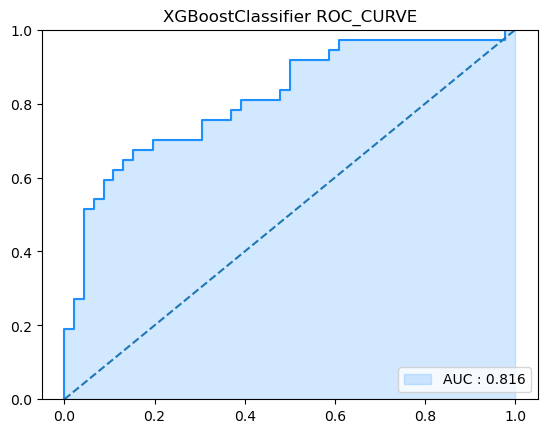

In [21]:
fig,ax = plt.subplots()

ax.plot(fpr,tpr, c = 'dodgerblue')
ax.fill_between(fpr,tpr,0, color = 'dodgerblue', alpha = 0.2,
                label = f'AUC : {auc_score}')
ax.plot([0,1],[0,1], ls = '--')
ax.set_ylim([0,1])
ax.legend(loc = 'lower right')
ax.set_title('XGBoostClassifier ROC_CURVE')

# Submission

In [22]:
model.fit(X,Y) #Train.csv
proba = model.predict_proba(test.drop('id',axis = 1))[:,1]

In [23]:
sub = pd.read_csv('C:/Users/whileduck/Downloads/playground-series-s3e12/sample_submission.csv')
sub['target'] = proba

In [24]:
sub.to_csv('submission.csv',index = False)

pd.read_csv('submission.csv')

,id,target
0,414,0.134030
1,415,0.746625
2,416,0.838702
3,417,0.529852
4,418,0.176348
...,...,...
271,685,0.898664
272,686,0.071405
273,687,0.750040
274,688,0.066227
